In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from collections import Counter
# svg output in plots
import numpy as np
import tqdm as tqdm
from itertools import chain
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Parameters

In [6]:
# Load data
df = pd.read_pickle(r"../Dataset/dataframe.pkl")
df = df[df["Time"] > 1980]

df_i = df.explode("Simplices").reset_index()
all_authors = df_i["Simplices"].unique()
N_a = len(all_authors)
print("Number of authors:", N_a)

Number of authors: 1153729


In [7]:
### Initial condition age distribution

df_all = pd.read_pickle(r"../Dataset/dataframe.pkl")
df_all = df_all.explode("Simplices").reset_index()
all_ini = df_all.groupby("Simplices").min("Time").reset_index()

all_ini["Age"] = 1980 -  all_ini["Time"]

(array([0.00915608, 0.0088015 , 0.00946339, 0.00894333, 0.00866755,
        0.00863603, 0.00873846, 0.00928215, 0.00904577, 0.00914032,
        0.00894333, 0.00927427, 0.00855723, 0.00878574, 0.00915608,
        0.00900637, 0.00940035, 0.00888818, 0.00890393, 0.00933731,
        0.0091482 , 0.00942399, 0.00939247, 0.00921912, 0.00910092,
        0.00895121, 0.00923488, 0.00902213, 0.00908516, 0.00929791,
        0.00917972, 0.00932155, 0.00895909, 0.00940035, 0.00891181,
        0.00899849, 0.00923488, 0.00898273, 0.00889605, 0.00925852,
        0.0091482 , 0.00901425, 0.00888818, 0.00925852, 0.0088803 ,
        0.00904577, 0.00904577, 0.00895121, 0.00932943, 0.00900637,
        0.00909304, 0.00928215, 0.00906153, 0.00896697, 0.00936883,
        0.00851783, 0.00914032, 0.00916396, 0.00927427, 0.00896697,
        0.00936095, 0.0095343 , 0.00891181, 0.00942399, 0.00854935,
        0.00880938, 0.00909304, 0.00925064, 0.0091482 , 0.00916396,
        0.00917184, 0.00915608, 0.0091482 , 0.00

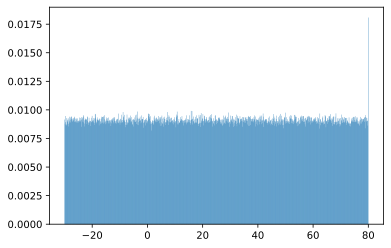

In [9]:
#x = plt.hist(all_ini["Age"], bins=1000, density=True, cumulative=False);

#plt.plot(x[1][1:], x[0], label="Initial condition")

### Academic age distribution
#plt.plot(x_life,f_life,color="black",linestyle="",marker=".",linewidth=4)

all_ages = np.random.choice(x_life, size=len(all_authors))

plt.hist(all_ages, bins=1000, density=True, cumulative=False, label="Academic age distribution")

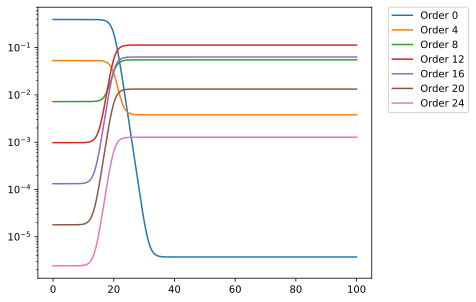

In [10]:
def dist_order(order,age,N):
    alpha = 0.5*(1 + np.tanh(0.5*(age-20)))
    s = 0.5
    Z = np.sum([np.exp(-0.5*o) for o in range(N)])
    e = np.exp(-0.5*order)/Z
    lam = N/2
    Pois = np.exp(-lam)*lam**(order)/np.math.factorial(order)
    return (1-alpha)*e + alpha*Pois

fig, ax = plt.subplots(figsize=(6,5))
v = np.linspace(0,100, 1001)
for order in range(0, 25, 4):
    plt.plot(v, dist_order(order, v, 25), label="Order {}".format(order))
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout
plt.yscale("log")

In [11]:
t0 = 1950
tf = 2021

# Not all authors at the reservoir
N_a = 100
authors = np.array(all_authors[0:N_a])
ages = np.array(all_ages[0:N_a])

# Parameters
N = 25 # Maximum number of orders
r = 5000 #(np.log(10**5 - 10**3))/60 # simplices x year
N_simplices = 1000 # Number of simplices at t0

# Memory matrix
M = np.ones((N_a,N_a))

# If the ages are < 0 or > age_max, we set M = 0
age_max = 80

ti = t0

simplices = []
time = []

def p(x, age_max=age_max):
    if x > age_max:
        return 0
    elif x <= 0:
        return 0
    else:
        return 1/(1+x)

def dist_order(order,age,N):
    alpha = 0.5*(1 + np.tanh(0.5*(age-20)))
    s = 0.4
    Z = np.sum([np.exp(-s*o) for o in range(N)])
    e = np.exp(-s*order)/Z
    lam = (N)/3
    Pois = np.exp(-lam)*lam**(order)/np.math.factorial(order)
    return (1-alpha)*e + alpha*Pois

w_t = 0
print("Model starts running")
while ti < tf:
    # Compute total rate:
    W = (r+1)
    
    # Compute next event time
    At = - np.log(np.random.rand())/W
    
    # Time goes on
    ti = ti + At
    w_t = w_t + At
    ages = ages + At

    # Choose main author according to the age
    possible_authors = np.where(ages > 0)[0]
    i_a = np.random.randint(0,len(possible_authors))
    i_a = possible_authors[i_a]
    while np.random.rand() > p(ages[i_a]):
        i_a = np.random.randint(0,N_a)
    
    # i_a is the main author
    age = ages[i_a]
    o_i = np.random.choice(range(N),p=[dist_order(order,age,N) for order in range(N)]/np.sum([dist_order(order,age,N) for order in range(N)]))
    if o_i > 0:
        possible_collaborators_index = np.where(ages > 0)[0]
        # random choice with preferential attachment from authors to select the collaborators
        i_c = np.random.choice(possible_collaborators_index,size=o_i,replace=False)
        collaborators = [authors[i] for i in i_c]
        # We update the memory matrix with the new collaboration
        if o_i > 5:
            simplices.append([authors[i_a]] + collaborators)
            time.append(ti)
    if w_t > 1:
        N_simplices = len(simplices)
        print(ti,N_simplices)
        w_t = 0

Model starts running
1951.000054528631 1925
1952.0000811145617 3968
1953.0001776147265 5979
1954.0001899787662 8055
1955.0007405539725 9811
1956.0008523909505 11502
1957.0009791680432 13079
1958.0016176527781 14737
1959.001712332198 16516
1960.001983070928 18553
1961.0020602403577 20720
1962.002198682313 23067
1963.0028508499988 25486
1964.003009575183 28152
1965.0030359062534 30275
1966.0031209827064 32636
1967.0037775224307 34866
1968.0038734200625 37258
1969.0041052024103 39226
1970.0041634956785 41161
1971.00446008486 42830
1972.004693476949 44492
1973.0051369510918 46115
1974.0054789838714 47890
1975.0055324247396 49732
1976.0057163708354 51255
1977.0061683790807 52645
1978.006308752746 54156
1979.0063453941175 55968
1980.0064781868277 57898
1981.0067103304948 59892
1982.0068727853004 62004
1983.006960669939 64235
1984.0070636510952 66518
1985.0071874738385 68871
1986.0074511948287 71303
1987.0074865224256 73809
1988.0079037527003 76569
1989.0081486874471 79429
1990.0082573158459 

In [14]:
df = pd.DataFrame({"Time":time,"Simplices":simplices})

In [15]:
df.to_pickle("./Outcomes/Minimal_model_random.pkl")